#### Proses PCA dibagi menjadi 3 tahapan (poin) utama yaitu:

1. Split data dengan K-Fold
2. Proses PCA (mengambil bobot dan proyeksi matriks dari data train)
3. Proses Testing dan hasil akurasi

Tahapan lengkapnya (PCA) ada dibawah ini:
1. Import data image dari github
2. Membagi dataset menjadi data train dan test dengan K-Fold
3. Proses PCA, mengambil bobot dan proyeksi matriks dari data training
4. Menghitung bobot data test
5. Menghitung jarak dari bobot data test dengan data train
6. Mencari posisi data test (orang ke, pose ke)
7. Menghitung akurasi dari posisi data test dengan data asli


# Import image from Github

In [ ]:
_ = !git clone https://github.com/AchmadBauravindah/datas_for_ai.git

In [ ]:
import cv2 # Untuk mengambil pixel dari image
import pandas as pd # Membantu membuat dataframe
import numpy as np # Membantu proses operasi matriks dan matematika
from sklearn.model_selection import KFold # Membantu split data sebanyak k fold
from sklearn.metrics.pairwise import manhattan_distances # Membantu mencari jarak manhattan
import math # Membantu proses operasi matematika

# 1. K-Fold

In [ ]:
# K-FOLD
path = "datas_for_ai/biometrika/orl_face/"

def k_fold_split():
  jumlah_orang = 40 # Jumlah orang pada data orl
  jumlah_pose = 10 # Jumlah pose pada data orl

  nama_file_depan = 'ORL_'
  nama_file_belakang = '.jpg'

  dataset_train_face = [] # Menyimpan matriks data train semua fold
  dataset_test_face = [] # Menyimpan matriks data test semua fold

  kf = KFold(n_splits=5) # Menentukan jumlah fold

  split_pose = np.linspace(1, 10, 10) # Membuat array untuk identifier indeks pose

  fold_ke = 1
  for train_i, test_i in kf.split(split_pose): # Proses K-FOLD
    print("Indeks Fold Ke - {}".format(fold_ke), train_i, test_i)
    fold_ke +=1
    # Agar indeks mulai dari 1
    train_i = train_i + 1
    test_i = test_i + 1
    train_face = [] # Menyimpan data train per fold
    test_face = [] # Menyimpan data test per fold
    for orang_ke in np.linspace(1, 40, 40).astype(np.int8): # Orang (40 Orang)
      for pose_ke in np.linspace(1, 10, 10).astype(np.int8): # Pose (10 Pose)
        if pose_ke in train_i:
          nama_file = nama_file_depan + str(orang_ke) + '_' + str(pose_ke) + nama_file_belakang
          nama_file = path + nama_file
          img = cv2.imread(nama_file, 0)
          # print("Shape of image", img.shape)
          high_level_img = img.reshape(-1)
          train_face.append(high_level_img)
        else:
          nama_file = nama_file_depan + str(orang_ke) + '_' + str(pose_ke) + nama_file_belakang
          nama_file = path + nama_file
          img = cv2.imread(nama_file, 0)
          high_level_img = img.reshape(-1)
          test_face.append(high_level_img)
    dataset_train_face.append(train_face)
    dataset_test_face.append(test_face)
  return dataset_train_face, dataset_test_face
        

### Proses split dataset sebanyak 5 Fold

In [ ]:
train, test = k_fold_split()

Indeks Fold Ke - 1 [2 3 4 5 6 7 8 9] [0 1]
Indeks Fold Ke - 2 [0 1 4 5 6 7 8 9] [2 3]
Indeks Fold Ke - 3 [0 1 2 3 6 7 8 9] [4 5]
Indeks Fold Ke - 4 [0 1 2 3 4 5 8 9] [6 7]
Indeks Fold Ke - 5 [0 1 2 3 4 5 6 7] [8 9]


# 2. PCA

In [ ]:
def PCA(data):
  # 1. Ukuran Data
  (baris, kolom) = data.shape
  # 2. Hitung Rata-rata
  average = np.mean(data, axis = 0)
  # 3. Hitung Zero Mean
  data_ganda = np.tile(average, (baris, 1)) # np.tile(data yang di repeat, (jumlah repeat, 1: axis y))
  zero_mean = data - data_ganda
  # 4. Hitung Kovarian
  cov_matrix = (1/(baris-1)) * zero_mean @ np.transpose(zero_mean)
  # 5. Hitung eigen vektor dan eigen value
  [eigen_value, eigen_vector] = np.linalg.eig(cov_matrix)
  # 6. Hitung Proyeksi Matriks
  matrix_projection = np.transpose(zero_mean) @ eigen_vector
  matrix_projection = np.transpose(matrix_projection)
  # 7. Hitung Matrix Bobot
  matrix_weight = data @ np.transpose(matrix_projection)
  # print("Zero Mean : ", zero_mean.shape)
  # print("Kovarian : ", cov_matrix.shape)
  # print("Eigen Value : ", eigen_value.shape)
  # print("Eigen Vektor : ", eigen_vector.shape)
  # print("Proyeksi Matriks : ", matrix_projection.shape)
  # print("Bobot Matriks : ", matrix_weight.shape)
  return matrix_projection, matrix_weight

# 3. Proses Testing dan Hasil Akurasi

### - Mendapatkan Weight Data Test
*weight data test = data test * transpose(proyeksi matriks data train)*


In [ ]:
def getWeightDataTest(data_test, projection_matrices):
  weight = data_test @ np.transpose(projection_matrices)
  return weight # keluaranya matrix 1x320

### - Mendapatkan jarak terdekat dari data test
*jarak = data test weight - data train weight*

In [ ]:
def getDistances(data_test_weight, data_train_weights):
  manhattan_result = []
  for data_train_weight in data_train_weights:
    hasil = manhattan_distances(data_test_weight.reshape(1, -1), data_train_weight.reshape(1, -1))
    manhattan_result.append(hasil)
  return manhattan_result

### - Mendapatkan jarak minimum dari hasil jarak terdekat
*jarak minimum = min(jarak)*

In [ ]:
def getMinimumIndexDistances(distances):
    minimum_index_distances = np.argmin(distances)
    return minimum_index_distances

### - Mendapatkan posisi image data test

*posisi image = orang ke, pose ke*

In [ ]:
def getPositionImage(distances):
  jumlah_pose = 8 # setelah di fold data menjadi 8 pose
  baris_ke = getMinimumIndexDistances(distances) # Baris ke berapa dalam dataset 320 itu
  orang_ke = int(math.ceil(baris_ke/jumlah_pose)) # 0.1 atau 0.9 akan menjadi 1 karena math.ceil
  pose_ke = np.mod(baris_ke, jumlah_pose) # Pose ke berapa dalam 8 pose tiap orang itu
  if pose_ke == 0:
    pose_ke = jumlah_pose
  return orang_ke, pose_ke

### - Proses testing PCA
*PCA Results akan menghasilkan posisi image pada data test*

In [ ]:
def testingPCA(data_tests, data_train_projection, data_train_weights):
  PCA_Results = []

  # Mengambil Data Test fold ke-5
  for data_test in data_tests:
    # Mendapatkan weight dari data test
    data_test_weight = getWeightDataTest(data_test, data_train_projection)

    # distance : weight data test (1x320) - weight data train (320x320)
    distances = getDistances(data_test_weight, data_train_weights)

    # Menghitung jarak terdekat
    orang_ke, pose_ke = getPositionImage(distances)
    PCA_Results.append([orang_ke, pose_ke])

  PCA_Results = np.array(PCA_Results)
  return PCA_Results

### - Mendapatkan Hasil Akurasi PCA semua Fold (5 Fold)
*Mendapatkan akurasi dari hasil testing*

In [ ]:
def getAccuracyPCA(hasil_test_PCA):
  # Membuat array untuk kelas asli, jika di data test ada 2 pose maka kelas ke-1 memiliki 2 pose (1, 1)
  kelas_asli = (np.linspace(1, 40, 40).astype(int))
  kelas_asli = np.repeat(kelas_asli, 2)

  # Mendapatkan hasil kelas (orang_ke) apa dari hasil PCA
  kelas_test = hasil_test_PCA[:, [0]]  

  akurasi = ((kelas_asli != kelas_test).sum()) / np.size(kelas_asli)
  return akurasi

*Menyimpan hasil PCA*

In [ ]:
hasil_test_PCA_semua_fold = [] # array untuk simpan hasil PCA tiap fold

*Mendapatkan hasil PCA semua Fold (5 Fold)*

In [ ]:
for data_train_per_fold, data_test_per_fold in zip(train, test):
  data_train = np.array(data_train_per_fold) # Ubah list biasa menjadi list numpy
  data_test = np.array(data_test_per_fold) # Ubah list biasa menjadi list numpy

  projection_train, weight_train = PCA(data_train) # Mendapatkan proyeksi dan bobot data train

  hasil_test_PCA = testingPCA(data_test, projection_train, weight_train) # Mendapatkan hasil PCA yang berisi array orang_ke, pose_ke
  hasil_test_PCA_semua_fold.append(hasil_test_PCA) # Menyimpan hasil PCA data test

*Menampilkan hasil akurasi PCA semua Fold (5 Fold)*

In [ ]:
fold = 1 # Fold dimulai dari fold 1
for hasil_test_PCA_per_fold in hasil_test_PCA_semua_fold:
  print("Fold - {} = ".format(fold), getAccuracyPCA(hasil_test_PCA_per_fold))
  fold+=1

Fold - 1 =  78.0
Fold - 2 =  78.0
Fold - 3 =  78.0
Fold - 4 =  78.025
Fold - 5 =  78.0


### Mendapatkan image dari orang ke, pose ke

In [ ]:
def getImage(orang_ke, pose_ke):
  nama_file_depan = 'ORL_'
  nama_file_belakang = '.jpg'
  nama_file = nama_file_depan + str(orang_ke) + '_' + str(pose_ke) + nama_file_belakang
  nama_file = path + nama_file
  img = cv2.imread(nama_file, 0)
  return img

### Contoh 1 sampel
###### data test : orang ke - 1, pose ke - 7 
###### data asli : orang ke - 1, pose ke - 1

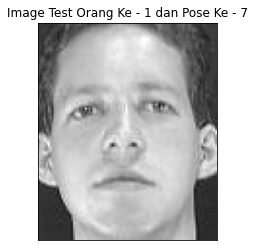

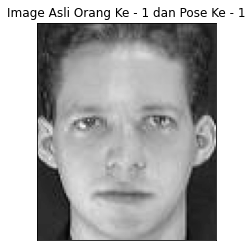

In [ ]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image

hasil_test_PCA_fold_5 = hasil_test_PCA_semua_fold[4]

# Image Test
orang_ke = hasil_test_PCA_fold_5[0][0]
pose_ke = hasil_test_PCA_fold_5[0][1]
image = getImage(orang_ke, pose_ke)
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.title('Image Test Orang Ke - {} dan Pose Ke - {}'.format(orang_ke, pose_ke)), plt.xticks([]), plt.yticks([])
plt.show()

# Image Asli
orang_ke = 1
pose_ke = 1
image = getImage(orang_ke, pose_ke)
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.title('Image Asli Orang Ke - {} dan Pose Ke - {}'.format(orang_ke, pose_ke)), plt.xticks([]), plt.yticks([])
plt.show()
